In [1]:
import pypsa 
import atlite 
import vresutils.shapes as vshapes
from vresutils.graph import voronoi_partition_pts
import geopandas as gpd
import powerplantmatching as pm
import pandas as pd
from scipy.spatial import KDTree
import numpy as np
import geopandas as gpd

from pypsa.opt import Constraint as Con

import matplotlib.pyplot as plt
%matplotlib inline
import xarray as xr

In [2]:
!hostname

resi


# Transfer Ninja Time Series to FIAS model

In [3]:
n = pypsa.Network('vietnam3.nc')

INFO:pypsa.io:Imported network vietnam3.nc has buses, carriers, generators, lines, loads, storage_units


In [4]:
len(n.generators_t.p_max_pu.columns)/2

69.0

## Download 2015 data

In [ ]:
n = pypsa.Network('vietnam3.nc')

In [4]:
def latitude_optimal(lon, lat):
    if (lat.values < 0).any():
        raise NotImplementedError('Not implemented for negative latitudes')

    slope = np.empty_like(lat.values)
    
    lon = lon.apply(np.deg2rad)
    lat = lat.apply(np.deg2rad)

    below_25 = lat.values <= np.deg2rad(25)
    below_50 = lat.values <= np.deg2rad(50)

    slope[below_25] = 0.87 * lat.values[below_25]
    slope[~below_25 & below_50] = 0.76 * lat.values[~below_25 & below_50] + np.deg2rad(0.31)
    slope[~below_50] = np.deg2rad(40.)

    return pd.Series(slope, index=lat.index)

In [5]:
buses = n.buses[['x','y']]
buses['slope'] = np.rad2deg(latitude_optimal(n.buses['x'], n.buses['y']))

/home/schlott/.local/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [6]:
buses

,x,y,slope
name,,,
HiepHoa,105.904364,21.335112,18.561547
LaiChauH,102.984253,22.137909,19.259981
DongAnh,105.897505,21.163109,18.411905
SonLa,104.001312,21.537377,18.737518
SonLaH,103.996409,21.497521,18.702843
MongDuong1,107.346737,21.073995,18.334376
MongDuong2,107.349981,21.073477,18.333925
QuangNinh,107.130358,21.038549,18.303538
NghiSon,105.720356,19.315539,16.804519


In [7]:
atlite.convert.get_windturbineconfig('Vestas_V112_3MW')

{'P': 3.06,
 'POW': [0.0,
  0.0,
  0.005,
  0.15,
  0.3,
  0.525,
  0.905,
  1.375,
  1.95,
  2.58,
  2.96,
  3.05,
  3.06,
  3.06,
  0.0],
 'V': [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 25, 25],
 'hub_height': 80.0}

In [8]:
atlite.convert.get_solarpanelconfig('CSi')

{'c_temp_amb': 1,
 'c_temp_irrad': 0.035,
 'efficiency': 0.1,
 'inverter_efficiency': 0.9,
 'k_1': -0.017162,
 'k_2': -0.040289,
 'k_3': -0.004681,
 'k_4': 0.000148,
 'k_5': 0.000169,
 'k_6': 5e-06,
 'model': 'huld',
 'name': 'CSi',
 'r_irradiance': 1000,
 'r_tamb': 293,
 'r_tmod': 298,
 'source': 'Huld 2010'}

## Data Processing

In [3]:
import sys
import os

In [4]:
n = pypsa.Network('vietnam3.nc')

INFO:pypsa.io:Imported network vietnam3.nc has buses, carriers, generators, lines, loads, storage_units


In [5]:
cd original-model_ninja-data/2015/data/

/home/schlott/Vietnam/ReVietSys/original-model_ninja-data/2015/data


In [6]:
files=os.listdir('./')
files.sort()

In [7]:
files

['ninja_pv_10.1337_105.6713_uncorrected_OMon.csv',
 'ninja_pv_10.4115_106.1943_uncorrected_MyTho.csv',
 'ninja_pv_10.6065_107.0402_uncorrected_PhuMy.csv',
 'ninja_pv_10.7015_106.7187_uncorrected_NhaBe.csv',
 'ninja_pv_10.7389_106.6018_uncorrected_PhuLam.csv',
 'ninja_pv_10.8541_106.4168_uncorrected_DucHoa.csv',
 'ninja_pv_10.9409_106.5688_uncorrected_CauBong.csv',
 'ninja_pv_10.9646_107.4059_uncorrected_LongThanh.csv',
 'ninja_pv_10.9714_106.9540_uncorrected_SongMay.csv',
 'ninja_pv_10.9983_106.7656_uncorrected_TanUyen.csv',
 'ninja_pv_11.0406_106.6871_uncorrected_TanDinh.csv',
 'ninja_pv_11.0922_106.4434_uncorrected_CuChi.csv',
 'ninja_pv_11.3186_108.8033_uncorrected_VinhTan.csv',
 'ninja_pv_11.4370_106.6574_uncorrected_ChonThanh.csv',
 'ninja_pv_11.6114_108.0903_uncorrected_DiLinh.csv',
 'ninja_pv_11.9679_107.6361_uncorrected_DakNong.csv',
 'ninja_pv_12.5268_109.2318_uncorrected_VanPhong.csv',
 'ninja_pv_13.9036_107.9616_uncorrected_Pleiku2.csv',
 'ninja_pv_14.1025_107.9462_uncorrect

In [8]:
f = pd.read_csv(files[0], header=2, index_col=0)
p_max_pu = pd.DataFrame(index=f.index)

import re
for file in files:
    f = pd.read_csv(file, header=2, index_col=0)
    for bus in n.buses.index:
        bus = re.search('(?=)'+bus, file)
        if bus is None:
            continue
        else:
            print(bus.group(0))
            if file[0:10] == 'ninja_wind':
                print('wind')
                p_max_pu[bus.group(0)+' '+'wind'] = f['kW']
            elif file[0:8] == 'ninja_pv':
                print('pv')
                p_max_pu[bus.group(0)+' '+'solar'] = f['kW']

OMon
pv
MyTho
pv
PhuMy
pv
NhaBe
pv
PhuLam
pv
DucHoa
pv
CauBong
pv
LongThanh
pv
SongMay
pv
TanUyen
pv
TanDinh
pv
CuChi
pv
VinhTan
pv
ChonThanh
pv
DiLinh
pv
DakNong
pv
VanPhong
pv
Pleiku
pv
Pleiku2
pv
Pleiku
pv
Yali
pv
DocSoi
pv
ThanhMy
pv
DaNang
pv
VungAng
pv
HaTinh
pv
NghiSon
pv
CongThanh
pv
NamDinh1
pv
NhoQuan
pv
ThuongTin
pv
TayHaNoi
pv
PhoNoi
pv
ThangLongT
pv
QuangNinh
pv
MongDuong2
pv
MongDuong1
pv
DongAnh
pv
HiepHoa
pv
VietTri
pv
SonLa
pv
SonLaH
pv
SonLa
pv
HoaBinh
pv
LaiChauH
pv
LaiChau
pv
LaiChau
pv
DuyenHai
pv
LongPhu
pv
OMon
wind
MyTho
wind
PhuMy
wind
NhaBe
wind
PhuLam
wind
DucHoa
wind
CauBong
wind
LongThanh
wind
SongMay
wind
TanUyen
wind
TanDinh
wind
CuChi
wind
VinhTan
wind
ChonThanh
wind
DiLinh
wind
DakNong
wind
VanPhong
wind
Pleiku
wind
Pleiku2
wind
Pleiku
wind
Yali
wind
DocSoi
wind
ThanhMy
wind
DaNang
wind
VungAng
wind
HaTinh
wind
NghiSon
wind
CongThanh
wind
NamDinh1
wind
NhoQuan
wind
ThuongTin
wind
TayHaNoi
wind
PhoNoi
wind
ThangLongT
wind
QuangNinh
wind
MongDuong2
wind
M

In [9]:
p_max_pu = p_max_pu.reindex(index=n.generators_t.p_max_pu[0:8760].index)
p_max_pu.to_csv('./../generators-p_max_pu.csv')

In [10]:
cd ../../../

/home/schlott/Vietnam/ReVietSys


In [11]:
#oops, here something goes wrong...
#p_max_pu = pd.read('./original-model_ninja-data/2015/generators-p_max_pu.csv')

In [12]:
p_max_pu.columns

Index(['OMon solar', 'MyTho solar', 'PhuMy solar', 'NhaBe solar',
       'PhuLam solar', 'DucHoa solar', 'CauBong solar', 'LongThanh solar',
       'SongMay solar', 'TanUyen solar', 'TanDinh solar', 'CuChi solar',
       'VinhTan solar', 'ChonThanh solar', 'DiLinh solar', 'DakNong solar',
       'VanPhong solar', 'Pleiku solar', 'Pleiku2 solar', 'Yali solar',
       'DocSoi solar', 'ThanhMy solar', 'DaNang solar', 'VungAng solar',
       'HaTinh solar', 'NghiSon solar', 'CongThanh solar', 'NamDinh1 solar',
       'NhoQuan solar', 'ThuongTin solar', 'TayHaNoi solar', 'PhoNoi solar',
       'ThangLongT solar', 'QuangNinh solar', 'MongDuong2 solar',
       'MongDuong1 solar', 'DongAnh solar', 'HiepHoa solar', 'VietTri solar',
       'SonLa solar', 'SonLaH solar', 'HoaBinh solar', 'LaiChauH solar',
       'LaiChau solar', 'DuyenHai solar', 'LongPhu solar', 'OMon wind',
       'MyTho wind', 'PhuMy wind', 'NhaBe wind', 'PhuLam wind', 'DucHoa wind',
       'CauBong wind', 'LongThanh wind', 'S

In [13]:
shifted = p_max_pu.shift(freq=pd.Timedelta(1,unit='h'))
first = p_max_pu.loc['2015-01-01 00:00:00'] * 0.0
first = pd.DataFrame(first).swapaxes(0,1)
shifted = pd.concat([first, shifted])
shifted.loc[shifted.index[0]] = shifted.loc[shifted.index[-1]]
shifted = shifted.drop(index=shifted.index[-1])

In [14]:
shifted

,OMon solar,MyTho solar,PhuMy solar,NhaBe solar,PhuLam solar,DucHoa solar,CauBong solar,LongThanh solar,SongMay solar,TanUyen solar,...,DongAnh wind,HiepHoa wind,VietTri wind,SonLa wind,SonLaH wind,HoaBinh wind,LaiChauH wind,LaiChau wind,DuyenHai wind,LongPhu wind
2015-01-01 00:00:00,0.031,0.036,0.047,0.041,0.039,0.034,0.038,0.053,0.046,0.042,...,0.046,0.064,0.005,0.001,0.001,0.015,0.002,0.003,0.619,0.371
2015-01-01 01:00:00,0.209,0.229,0.229,0.239,0.238,0.238,0.244,0.214,0.243,0.248,...,0.276,0.321,0.098,0.016,0.018,0.097,0.002,0.002,0.551,0.322
2015-01-01 02:00:00,0.391,0.410,0.403,0.408,0.412,0.420,0.421,0.349,0.401,0.415,...,0.243,0.291,0.068,0.052,0.055,0.070,0.009,0.009,0.542,0.367
2015-01-01 03:00:00,0.526,0.553,0.565,0.555,0.554,0.554,0.550,0.548,0.537,0.538,...,0.433,0.505,0.194,0.177,0.181,0.202,0.065,0.065,0.470,0.270
2015-01-01 04:00:00,0.625,0.648,0.660,0.654,0.652,0.649,0.653,0.659,0.656,0.654,...,0.407,0.466,0.205,0.181,0.188,0.205,0.082,0.081,0.452,0.206
2015-01-01 05:00:00,0.679,0.691,0.698,0.694,0.693,0.690,0.694,0.694,0.694,0.693,...,0.335,0.374,0.182,0.138,0.144,0.172,0.063,0.062,0.476,0.193
2015-01-01 06:00:00,0.679,0.683,0.687,0.685,0.684,0.682,0.685,0.683,0.683,0.683,...,0.242,0.259,0.150,0.102,0.105,0.137,0.046,0.046,0.473,0.181
2015-01-01 07:00:00,0.630,0.631,0.623,0.627,0.627,0.627,0.628,0.618,0.623,0.625,...,0.168,0.172,0.118,0.080,0.083,0.110,0.037,0.037,0.433,0.159
2015-01-01 08:00:00,0.536,0.531,0.504,0.516,0.519,0.523,0.522,0.496,0.511,0.517,...,0.121,0.121,0.091,0.068,0.070,0.089,0.036,0.034,0.383,0.139
2015-01-01 09:00:00,0.388,0.378,0.331,0.346,0.353,0.363,0.357,0.340,0.341,0.347,...,0.091,0.090,0.070,0.060,0.062,0.074,0.034,0.032,0.345,0.134


In [15]:
p_max_pu = shifted
p_max_pu

,OMon solar,MyTho solar,PhuMy solar,NhaBe solar,PhuLam solar,DucHoa solar,CauBong solar,LongThanh solar,SongMay solar,TanUyen solar,...,DongAnh wind,HiepHoa wind,VietTri wind,SonLa wind,SonLaH wind,HoaBinh wind,LaiChauH wind,LaiChau wind,DuyenHai wind,LongPhu wind
2015-01-01 00:00:00,0.031,0.036,0.047,0.041,0.039,0.034,0.038,0.053,0.046,0.042,...,0.046,0.064,0.005,0.001,0.001,0.015,0.002,0.003,0.619,0.371
2015-01-01 01:00:00,0.209,0.229,0.229,0.239,0.238,0.238,0.244,0.214,0.243,0.248,...,0.276,0.321,0.098,0.016,0.018,0.097,0.002,0.002,0.551,0.322
2015-01-01 02:00:00,0.391,0.410,0.403,0.408,0.412,0.420,0.421,0.349,0.401,0.415,...,0.243,0.291,0.068,0.052,0.055,0.070,0.009,0.009,0.542,0.367
2015-01-01 03:00:00,0.526,0.553,0.565,0.555,0.554,0.554,0.550,0.548,0.537,0.538,...,0.433,0.505,0.194,0.177,0.181,0.202,0.065,0.065,0.470,0.270
2015-01-01 04:00:00,0.625,0.648,0.660,0.654,0.652,0.649,0.653,0.659,0.656,0.654,...,0.407,0.466,0.205,0.181,0.188,0.205,0.082,0.081,0.452,0.206
2015-01-01 05:00:00,0.679,0.691,0.698,0.694,0.693,0.690,0.694,0.694,0.694,0.693,...,0.335,0.374,0.182,0.138,0.144,0.172,0.063,0.062,0.476,0.193
2015-01-01 06:00:00,0.679,0.683,0.687,0.685,0.684,0.682,0.685,0.683,0.683,0.683,...,0.242,0.259,0.150,0.102,0.105,0.137,0.046,0.046,0.473,0.181
2015-01-01 07:00:00,0.630,0.631,0.623,0.627,0.627,0.627,0.628,0.618,0.623,0.625,...,0.168,0.172,0.118,0.080,0.083,0.110,0.037,0.037,0.433,0.159
2015-01-01 08:00:00,0.536,0.531,0.504,0.516,0.519,0.523,0.522,0.496,0.511,0.517,...,0.121,0.121,0.091,0.068,0.070,0.089,0.036,0.034,0.383,0.139
2015-01-01 09:00:00,0.388,0.378,0.331,0.346,0.353,0.363,0.357,0.340,0.341,0.347,...,0.091,0.090,0.070,0.060,0.062,0.074,0.034,0.032,0.345,0.134


### No Storage

In [15]:
n = pypsa.Network('vietnam3_PHS.nc')
n.generators_t.p_max_pu[p_max_pu.columns] = p_max_pu

INFO:pypsa.io:Imported network vietnam3_PHS.nc has buses, carriers, generators, lines, loads, storage_units


In [16]:
n.generators_t.p_max_pu[p_max_pu.columns][0:8760] == p_max_pu

name,OMon solar,MyTho solar,PhuMy solar,NhaBe solar,PhuLam solar,DucHoa solar,CauBong solar,LongThanh solar,SongMay solar,TanUyen solar,...,DongAnh wind,HiepHoa wind,VietTri wind,SonLa wind,SonLaH wind,HoaBinh wind,LaiChauH wind,LaiChau wind,DuyenHai wind,LongPhu wind
name,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
2015-01-01 01:00:00,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
2015-01-01 02:00:00,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
2015-01-01 03:00:00,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
2015-01-01 04:00:00,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
2015-01-01 05:00:00,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
2015-01-01 06:00:00,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
2015-01-01 07:00:00,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
2015-01-01 08:00:00,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True


In [17]:
n.export_to_netcdf('vietnam3_ninja_PHS.nc')

INFO:pypsa.io:Exported network vietnam3_ninja.nc has loads, carriers, lines, buses, generators, storage_units


<xarray.Dataset>
Dimensions:                            (buses_i: 46, carriers_i: 12, generators_i: 414, generators_t_p_max_pu_i: 138, lines_i: 65, loads_i: 46, loads_t_p_set_i: 46, snapshots: 17544, storage_units_i: 46, storage_units_t_inflow_i: 46)
Coordinates:
  * snapshots                          (snapshots) datetime64[ns] 2015-01-01 ...
  * loads_i                            (loads_i) object 'HiepHoa' 'LaiChauH' ...
  * loads_t_p_set_i                    (loads_t_p_set_i) object 'HiepHoa' ...
  * carriers_i                         (carriers_i) object 'bioenergy' ...
  * lines_i                            (lines_i) object '1' '2' '3' '4' '5' ...
  * buses_i                            (buses_i) object 'HiepHoa' 'LaiChauH' ...
  * generators_i                       (generators_i) object 'CongThanh hard coal' ...
  * generators_t_p_max_pu_i            (generators_t_p_max_pu_i) object 'HiepHoa solar' ...
  * storage_units_i                    (storage_units_i) object 'ChonThanh hydro'

In [20]:
n.storage_units.efficiency_dispatch, n.storage_units.efficiency_store

(storage_units_i
 ChonThanh hydro     0.9
 DaNang hydro        0.9
 DakNong hydro       0.9
 DiLinh hydro        0.9
 DocSoi hydro        0.9
 HaTinh hydro        0.9
 HiepHoa hydro       0.9
 HoaBinh hydro       0.9
 LaiChau hydro       0.9
 LaiChauH hydro      0.9
 NghiSon hydro       0.9
 NhoQuan hydro       0.9
 Pleiku hydro        0.9
 Pleiku2 hydro       0.9
 SonLa hydro         0.9
 SonLaH hydro        0.9
 SongMay hydro       0.9
 TayHaNoi hydro      0.9
 ThanhMy hydro       0.9
 VanPhong hydro      0.9
 VinhTan hydro       0.9
 Yali hydro          0.9
 CauBong hydro       0.9
 CongThanh hydro     0.9
 CuChi hydro         0.9
 DongAnh hydro       0.9
 DucHoa hydro        0.9
 DuyenHai hydro      0.9
 LongPhu hydro       0.9
 LongThanh hydro     0.9
 MongDuong1 hydro    0.9
 MongDuong2 hydro    0.9
 MyTho hydro         0.9
 NamDinh1 hydro      0.9
 NhaBe hydro         0.9
 OMon hydro          0.9
 PhoNoi hydro        0.9
 PhuLam hydro        0.9
 PhuMy hydro         0.9
 QuangNi

### Test

In [21]:
n1 = pypsa.Network('vietnam3_PHS.nc')
n2 = pypsa.Network('vietnam3_ninja_PHS.nc')

INFO:pypsa.io:Imported network vietnam3_PHS.nc has buses, carriers, generators, lines, loads, storage_units
INFO:pypsa.io:Imported network vietnam3_ninja.nc has buses, carriers, generators, lines, loads, storage_units


In [22]:
n1.generators_t.p_max_pu.columns == n2.generators_t.p_max_pu.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

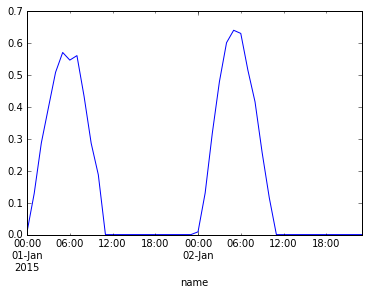

In [23]:
n1.generators_t.p_max_pu['OMon solar'][0:48].plot()

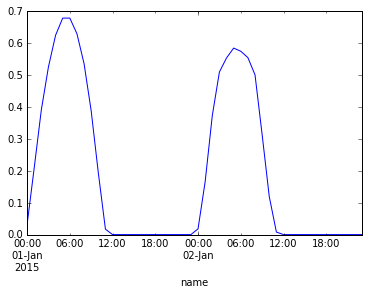

In [24]:
n2.generators_t.p_max_pu['OMon solar'][0:48].plot()

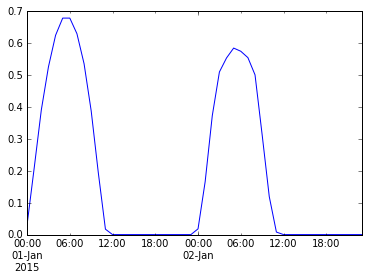

In [25]:
p_max_pu['OMon solar'][0:48].plot()

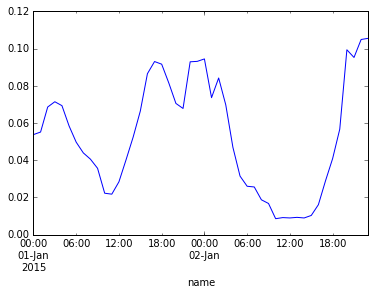

In [26]:
n1.generators_t.p_max_pu['OMon wind'][0:48].plot()

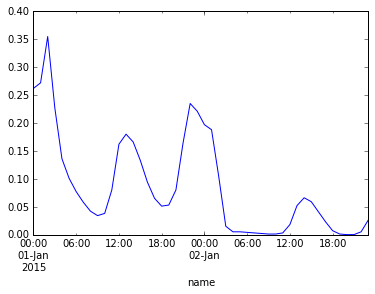

In [27]:
n2.generators_t.p_max_pu['OMon wind'][0:48].plot()

In [28]:
n1.generators_t.p_max_pu[n1.buses.index + ' hydro ror'] == n2.generators_t.p_max_pu[n2.buses.index + ' hydro ror']

name,HiepHoa hydro ror,LaiChauH hydro ror,DongAnh hydro ror,SonLa hydro ror,SonLaH hydro ror,MongDuong1 hydro ror,MongDuong2 hydro ror,QuangNinh hydro ror,NghiSon hydro ror,HoaBinh hydro ror,...,LaiChau hydro ror,TayHaNoi hydro ror,VietTri hydro ror,VanPhong hydro ror,CongThanh hydro ror,NamDinh1 hydro ror,LongPhu hydro ror,DucHoa hydro ror,TanUyen hydro ror,LongThanh hydro ror
name,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
2015-01-01 01:00:00,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
2015-01-01 02:00:00,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
2015-01-01 03:00:00,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
2015-01-01 04:00:00,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
2015-01-01 05:00:00,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
2015-01-01 06:00:00,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
2015-01-01 07:00:00,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
2015-01-01 08:00:00,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True


In [29]:
n2 = pypsa.Network('vietnam3_ninja_PHS.nc')

INFO:pypsa.io:Imported network vietnam3_ninja.nc has buses, carriers, generators, lines, loads, storage_units


### Storage

In [16]:
n = pypsa.Network('vietnam3_storage_PHS.nc')
n.generators_t.p_max_pu[p_max_pu.columns] = p_max_pu

INFO:pypsa.io:Imported network vietnam3_storage_PHS.nc has buses, carriers, generators, lines, loads, storage_units


In [17]:
n.generators_t.p_max_pu[p_max_pu.columns][0:8760] == p_max_pu

name,OMon solar,MyTho solar,PhuMy solar,NhaBe solar,PhuLam solar,DucHoa solar,CauBong solar,LongThanh solar,SongMay solar,TanUyen solar,...,DongAnh wind,HiepHoa wind,VietTri wind,SonLa wind,SonLaH wind,HoaBinh wind,LaiChauH wind,LaiChau wind,DuyenHai wind,LongPhu wind
name,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
2015-01-01 01:00:00,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
2015-01-01 02:00:00,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
2015-01-01 03:00:00,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
2015-01-01 04:00:00,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
2015-01-01 05:00:00,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
2015-01-01 06:00:00,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
2015-01-01 07:00:00,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
2015-01-01 08:00:00,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True


In [19]:
n.export_to_netcdf('vietnam3_ninja_storage_PHS.nc')

INFO:pypsa.io:Exported network vietnam3_ninja_storage_PHS.nc has carriers, storage_units, loads, buses, generators, lines


<xarray.Dataset>
Dimensions:                            (buses_i: 46, carriers_i: 12, generators_i: 414, generators_t_p_max_pu_i: 138, lines_i: 65, loads_i: 46, loads_t_p_set_i: 46, snapshots: 17544, storage_units_i: 138, storage_units_t_inflow_i: 46)
Coordinates:
  * snapshots                          (snapshots) datetime64[ns] 2015-01-01 ...
  * carriers_i                         (carriers_i) object 'bioenergy' ...
  * storage_units_i                    (storage_units_i) object 'ChonThanh hydro' ...
  * storage_units_t_inflow_i           (storage_units_t_inflow_i) object 'CauBong hydro' ...
  * loads_i                            (loads_i) object 'HiepHoa' 'LaiChauH' ...
  * loads_t_p_set_i                    (loads_t_p_set_i) object 'HiepHoa' ...
  * buses_i                            (buses_i) object 'HiepHoa' 'LaiChauH' ...
  * generators_i                       (generators_i) object 'CongThanh hard coal' ...
  * generators_t_p_max_pu_i            (generators_t_p_max_pu_i) object '

In [20]:
n.storage_units.efficiency_dispatch, n.storage_units.efficiency_store

(storage_units_i
 ChonThanh hydro       0.90
 DaNang hydro          0.90
 DakNong hydro         0.90
 DiLinh hydro          0.90
 DocSoi hydro          0.90
 HaTinh hydro          0.90
 HiepHoa hydro         0.90
 HoaBinh hydro         0.90
 LaiChau hydro         0.90
 LaiChauH hydro        0.90
 NghiSon hydro         0.90
 NhoQuan hydro         0.90
 Pleiku hydro          0.90
 Pleiku2 hydro         0.90
 SonLa hydro           0.90
 SonLaH hydro          0.90
 SongMay hydro         0.90
 TayHaNoi hydro        0.90
 ThanhMy hydro         0.90
 VanPhong hydro        0.90
 VinhTan hydro         0.90
 Yali hydro            0.90
 CauBong battery       0.90
 ChonThanh battery     0.90
 CongThanh battery     0.90
 CuChi battery         0.90
 DaNang battery        0.90
 DakNong battery       0.90
 DiLinh battery        0.90
 DocSoi battery        0.90
                       ... 
 ThuongTin hydrogen    0.58
 VanPhong hydrogen     0.58
 VietTri hydrogen      0.58
 VinhTan hydrogen      0.58
 Vu

In [21]:
n1 = pypsa.Network('vietnam3_storage_PHS.nc')
n2 = pypsa.Network('vietnam3_ninja_storage_PHS.nc')

INFO:pypsa.io:Imported network vietnam3_storage_PHS.nc has buses, carriers, generators, lines, loads, storage_units
INFO:pypsa.io:Imported network vietnam3_ninja_storage_PHS.nc has buses, carriers, generators, lines, loads, storage_units


In [22]:
n1.generators_t.p_max_pu[n1.buses.index + ' hydro ror'] == n2.generators_t.p_max_pu[n2.buses.index + ' hydro ror']

name,HiepHoa hydro ror,LaiChauH hydro ror,DongAnh hydro ror,SonLa hydro ror,SonLaH hydro ror,MongDuong1 hydro ror,MongDuong2 hydro ror,QuangNinh hydro ror,NghiSon hydro ror,HoaBinh hydro ror,...,LaiChau hydro ror,TayHaNoi hydro ror,VietTri hydro ror,VanPhong hydro ror,CongThanh hydro ror,NamDinh1 hydro ror,LongPhu hydro ror,DucHoa hydro ror,TanUyen hydro ror,LongThanh hydro ror
name,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
2015-01-01 01:00:00,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
2015-01-01 02:00:00,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
2015-01-01 03:00:00,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
2015-01-01 04:00:00,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
2015-01-01 05:00:00,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
2015-01-01 06:00:00,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
2015-01-01 07:00:00,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
2015-01-01 08:00:00,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
